In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import copy
from collections import namedtuple
from functools import partial
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

# This notebook will look at the convergence rate for different kinds of graphs
\*Even though gibbs isn't the best choice for getting a good marginal value, will include the plot of the marginal values that are sampled anyway

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.GM.Models.DiscreteGraphModels import *
from GenModels.GM.States.GraphicalMessagePassing import DataGraph

In [8]:
graphs = []
for _ in range( 20 ):
    line = DataGraph()
    for i in range( 1, 30 ):
        line.addEdge( parents=[ i-1 ], children=[ i ] )
    graphs.append( ( line, np.array( [] ) ) )

In [9]:
initial_shape, transition_shapes, emission_shape = GHMM.parameterShapes( graphs, d_latent=3, d_obs=4 )
initial_priors = np.ones( initial_shape )
transition_priors = [ np.ones( shape ) for shape in transition_shapes ]
emission_prior = np.ones( emission_shape )

In [10]:
true_model = GHMM( priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
for graph, fbs in graphs:

    true_model.setGraphs( [ ( graph, fbs ) ] )
    _, data = true_model.sampleStates()
    graph.setNodeData( data.keys(), data.values() )

In [11]:
print( true_model.params.initial_dist.pi )
print( [ dist.pi for dist in true_model.params.transition_dists ] )
print( true_model.params.emission_dist.pi )

[0.03577683 0.13680743 0.82741574]
[array([[0.22595569, 0.62252227, 0.15152204],
       [0.60167193, 0.3931233 , 0.00520477],
       [0.51636445, 0.14210561, 0.34152994]])]
[[0.13539297 0.30091445 0.56014678 0.0035458 ]
 [0.6812981  0.09905431 0.1962072  0.02344039]
 [0.43874359 0.06402206 0.48315836 0.01407599]]


# Test 1 - Deep graphs without cycles

In [12]:
em_model    = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
gibbs_model = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='Gibbs' )
cavi_model  = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='CAVI' )
svi_model   = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='SVI', step_size=0.1, minibatch_size=1 )

In [13]:
values = []
it = np.arange( 10 )
for _ in it:
    em_marginal    = em_model.fitStep()
    gibbs_marginal = gibbs_model.fitStep( return_marginal=True )
    elbo_cavi      = cavi_model.fitStep()
    elbo_svi       = svi_model.fitStep()
    values.append( [ em_marginal, gibbs_marginal, elbo_cavi, elbo_svi ] )
    print( values[ -1 ] )

[-1106.3270083210184, -1026.1566214515503, -1340.8326267991335, -67.0416313399567]
[-651.406862376312, -986.3456288950179, -689.0129558129248, -56.96387084300591]
[-651.3019926198732, -859.3319349839843, -689.0129558129247, -48.0781429622606]
[-651.2152829154431, -1037.302861019402, -689.0129558129238, -52.07116981384132]
[-651.1415695567623, -779.6775685562974, -689.0129558129238, -60.19542640597564]
[-651.077392840264, -837.7539057922845, -689.0129558129238, -52.7799483755916]
[-651.0203404484974, -970.5182509429658, -689.0129558129238, -57.23152730536701]
[-650.9686874026911, -792.4130751758668, -689.0129558129238, -61.403508549157294]
[-650.9211761024625, -853.7812738816808, -689.0129558129238, -56.54702287418607]
[-650.8768764648405, -973.3014414604793, -689.0129558129238, -57.77178897126754]


In [14]:
y1, y2, y3, y4 = zip( *values )

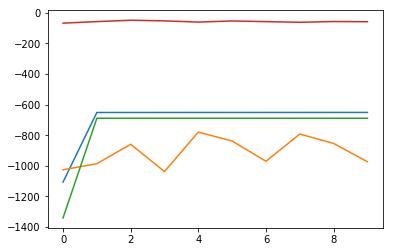

In [16]:
import matplotlib.pyplot as plt
plt.plot( it[ :10 ], y1[ :10 ] )
plt.plot( it[ :10 ], y2[ :10 ] )
plt.plot( it[ :10 ], y3[ :10 ] )
plt.plot( it[ :10 ], y4[ :10 ] )
plt.show()

# Test 2 - Wide graphs without cycles

# Test 3 - Deep graphs with cycles

# Test 4 - Wide graphs with cycles